In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import re

from tqdm import tqdm
from collections import Counter

import warnings
warnings.simplefilter(action='ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/grab/'
os.chdir(PATH)

In [0]:
PATH_LABELS = PATH + 'safety/labels'
PATH_FEATURES = PATH + 'safety/features'

In [4]:
labels_df = pd.read_csv(f'{PATH_LABELS}/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv')

labels_df.head()

,bookingID,label
0,111669149733,0
1,335007449205,1
2,171798691856,0
3,1520418422900,0
4,798863917116,0


In [5]:
len(labels_df), labels_df['bookingID'].nunique()

(20018, 20000)

In [0]:
df = pd.DataFrame()

In [7]:
gc.collect()

11

In [8]:
os.listdir(PATH_FEATURES)

for i in range(10):
    fn = f'{PATH_FEATURES}/part-0000' + str(i) + '-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv'
    curr_df = pd.read_csv(fn)
    df = pd.concat([df, curr_df])
    print(i, len(df))

0 1613554
1 3227112
2 4840667
3 6454220
4 8067779
5 9681330
6 11294883
7 12908439
8 14521999
9 16135561


In [10]:
df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,1202590843006,3.000,353.0,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000
1,274877907034,9.293,17.0,0.032775,8.659933,4.737300,0.024629,0.004028,-0.010858,257.0,0.190000
2,884763263056,3.000,189.0,1.139675,9.545974,1.951334,-0.006899,-0.015080,0.001122,973.0,0.667059
3,1073741824054,3.900,126.0,3.871543,10.386364,-0.136474,0.001344,-0.339601,-0.017956,902.0,7.913285
4,1056561954943,3.900,50.0,-0.112882,10.550960,-1.560110,0.130568,-0.061697,0.161530,820.0,20.419409


In [0]:
df = df.sort_values(by='bookingID')

In [12]:
df = df.reset_index(drop=True)

df.to_feather(f'{PATH_FEATURES}/train')

df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,0,16.0,142.124496,-0.660800,-9.543246,-1.814920,-0.002753,-0.035185,0.014585,183.0,0.227891
1,0,8.0,315.071838,-0.674707,-9.464740,-1.566092,-0.001937,-0.019093,0.009868,942.0,2.682516
2,0,16.0,144.125198,-1.183429,-8.491260,-3.712085,0.022289,-0.002134,0.052846,123.0,11.216825
3,0,16.0,243.958252,-0.600388,-11.128629,-0.485394,-0.034949,-0.021853,-0.012370,241.0,3.728397
4,0,8.0,38.000866,-0.889590,-8.826669,-1.920493,0.041287,-0.017650,0.033933,1037.0,12.354941


In [13]:
len(df)

16135561

Remove `bookingID` with different labels.

In [14]:
label_vc = labels_df['bookingID'].value_counts()

remove = label_vc[label_vc.values == 2].index.tolist()

print(len(remove))

18


In [0]:
save_df = labels_df[(~labels_df['bookingID'].isin(remove)) |
                      (labels_df['bookingID'].isin(remove) & labels_df['label']==1)]

In [19]:
len(save_df)

20000

In [20]:
save_df[save_df['bookingID'] == 13]

,bookingID,label
12602,13,1


In [0]:
save_df.to_csv(f'{PATH_LABELS}/labels_df.csv')

In [0]:
# df = df[~df['bookingID'].isin(remove)]

# print(len(df))

16135561
16116704


Add the number of appearances of a `bookingID`.

In [0]:
# df = pd.read_pickle(f'{PATH_FEATURES}/features_df.pkl')

vc = df['bookingID'].value_counts()

vc = pd.DataFrame(vc).reset_index()

vc = vc.rename(columns={'index': 'bookingID',
                        'bookingID': 'unique_counts'})

print(len(vc))

19982


In [0]:
train_df = pd.merge(df, vc,
                    left_on='bookingID', right_on='bookingID',
                    how='inner')

train_df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,unique_counts
0,0,16.0,142.124496,-0.660800,-9.543246,-1.814920,-0.002753,-0.035185,0.014585,183.0,0.227891,1004
1,0,8.0,315.071838,-0.674707,-9.464740,-1.566092,-0.001937,-0.019093,0.009868,942.0,2.682516,1004
2,0,16.0,144.125198,-1.183429,-8.491260,-3.712085,0.022289,-0.002134,0.052846,123.0,11.216825,1004
3,0,16.0,243.958252,-0.600388,-11.128629,-0.485394,-0.034949,-0.021853,-0.012370,241.0,3.728397,1004
4,0,8.0,38.000866,-0.889590,-8.826669,-1.920493,0.041287,-0.017650,0.033933,1037.0,12.354941,1004


In [0]:
vc = train_df['bookingID'].value_counts()

print('head')
print(vc.head())
print('tail')
print(vc.tail())

head
438086664371     7561
1374389534819    4499
34359738469      4302
1108101562533    3925
747324309632     3674
Name: bookingID, dtype: int64
tail
489626271850     120
1554778161275    120
592705486941     120
541165879344     120
575525617679     120
Name: bookingID, dtype: int64


The highest occurrences of `drivingID` is 7,561 while the lowest is 120.

In [0]:
train_df.groupby('bookingID')['Accuracy'].mean()[8:11]

bookingID
11     4.222360
14    20.283333
16     4.429040
Name: Accuracy, dtype: float64

In [0]:
# !pip install pyarrow

train_df.to_feather(f'{PATH_FEATURES}/train')

0    15017
1     5001
Name: label, dtype: int64


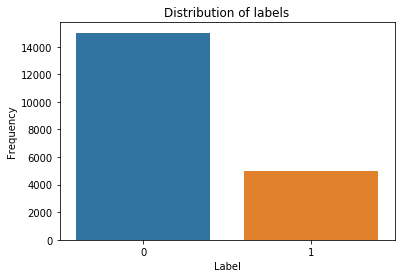

In [0]:
vc = labels_df['label'].value_counts()

print(vc)

# check distribution of target
plt.figure(figsize=(6,4))
plt.title('Distribution of labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
sns.barplot(vc.index,
            vc.values)
plt.show()

Distribution of labels is approximately 1:3. 